<a href="https://colab.research.google.com/github/finardi/tutos/blob/master/BERTOPIC_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install -q umap-learn
! pip install -q hdbscan
! pip install -q transformers

     |████████████████████████████████| 81kB 5.4MB/s 
     |████████████████████████████████| 1.2MB 17.1MB/s 
     |████████████████████████████████| 6.4MB 7.0MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 2.2MB 7.1MB/s 
     |████████████████████████████████| 870kB 37.4MB/s 
     |████████████████████████████████| 3.3MB 58.6MB/s 


In [2]:
import os
import gc
import umap
import torch
import hdbscan
import numpy as np
import pandas as pd
import logging
import matplotlib.pyplot as plt

from torch.utils.data import TensorDataset, DataLoader

from transformers import BertModel, BertTokenizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.datasets import fetch_20newsgroups
data = fetch_20newsgroups(subset='all')['data']

# BERTaú - Embeddings

In [7]:
data[:3]

["From: Mamatha Devineni Ratnam <mr47+@andrew.cmu.edu>\nSubject: Pens fans reactions\nOrganization: Post Office, Carnegie Mellon, Pittsburgh, PA\nLines: 12\nNNTP-Posting-Host: po4.andrew.cmu.edu\n\n\n\nI am sure some bashers of Pens fans are pretty confused about the lack\nof any kind of posts about the recent Pens massacre of the Devils. Actually,\nI am  bit puzzled too and a bit relieved. However, I am going to put an end\nto non-PIttsburghers' relief with a bit of praise for the Pens. Man, they\nare killing those Devils worse than I thought. Jagr just showed you why\nhe is much better than his regular season stats. He is also a lot\nfo fun to watch in the playoffs. Bowman should let JAgr have a lot of\nfun in the next couple of games since the Pens are going to beat the pulp out of Jersey anyway. I was very disappointed not to see the Islanders lose the final\nregular season game.          PENS RULE!!!\n\n",
 'From: mblawson@midway.ecn.uoknor.edu (Matthew B Lawson)\nSubject: Which h

In [6]:
%%time

try:
    del model
    gc.collect()
    torch.cuda.empty_cache()
except:
    pass

def get_embs(path_model:str, data, verbose=True):
    model = BertModel.from_pretrained(path_model).to('cuda')
    hidden_size = model.config.hidden_size
    embs = np.zeros(len(data)*hidden_size).reshape(len(data), hidden_size)

    for i, seq in enumerate(data):
        encoded_seq = tokenizer.encode_plus(
        seq, max_length=MAX_LEN, padding='max_length',
        truncation=True, return_token_type_ids=True,
        return_attention_mask=True, return_tensors='pt')

        outs = model(encoded_seq['input_ids'].to('cuda'), return_dict=True)
        last_hidden_state = outs['last_hidden_state']
        
        # without CLS and SEP
        embs_mean = torch.einsum("ijk -> k", last_hidden_state[:,1:-1,]).cpu().detach().numpy()
        
        embs[i] = embs_mean
        
        if verbose:
            if i%1000==0:
                print(f'Enbedded: {i}/{len(data)}')

    return embs

# --------------------------------------------------
MAX_LEN = 200
path_model = 'Itau-Unibanco/BERTau'
embeddings = get_embs(path_model, data)

Enbedded: 0/18846
Enbedded: 100/18846
Enbedded: 200/18846
Enbedded: 300/18846
Enbedded: 400/18846
Enbedded: 500/18846
Enbedded: 600/18846
Enbedded: 700/18846
Enbedded: 800/18846
Enbedded: 900/18846
Enbedded: 1000/18846
Enbedded: 1100/18846
Enbedded: 1200/18846
Enbedded: 1300/18846
Enbedded: 1400/18846
Enbedded: 1500/18846
Enbedded: 1600/18846
Enbedded: 1700/18846
Enbedded: 1800/18846
Enbedded: 1900/18846
Enbedded: 2000/18846
Enbedded: 2100/18846
Enbedded: 2200/18846
Enbedded: 2300/18846
Enbedded: 2400/18846
Enbedded: 2500/18846
Enbedded: 2600/18846
Enbedded: 2700/18846
Enbedded: 2800/18846
Enbedded: 2900/18846
Enbedded: 3000/18846
Enbedded: 3100/18846
Enbedded: 3200/18846
Enbedded: 3300/18846
Enbedded: 3400/18846
Enbedded: 3500/18846
Enbedded: 3600/18846
Enbedded: 3700/18846
Enbedded: 3800/18846
Enbedded: 3900/18846
Enbedded: 4000/18846
Enbedded: 4100/18846
Enbedded: 4200/18846
Enbedded: 4300/18846
Enbedded: 4400/18846
Enbedded: 4500/18846
Enbedded: 4600/18846
Enbedded: 4700/18846
Enbe

In [8]:
umap_embeddings = umap.UMAP(n_neighbors=15, 
                            n_components=5, 
                            metric='cosine').fit_transform(embeddings)

In [9]:
cluster = hdbscan.HDBSCAN(min_cluster_size=15,
                          metric='euclidean',                      
                          cluster_selection_method='eom').fit(umap_embeddings)

In [10]:
# Prepare data
umap_data = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)
result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = cluster.labels_

result

,x,y,labels
0,8.996622,13.827070,27
1,7.835275,12.350847,27
2,10.316415,11.980718,-1
3,12.649457,7.691959,26
4,7.445704,13.995874,27
...,...,...,...
18841,8.909996,10.954712,-1
18842,12.191648,10.171733,26
18843,7.638442,14.204132,27
18844,10.980890,10.698153,-1


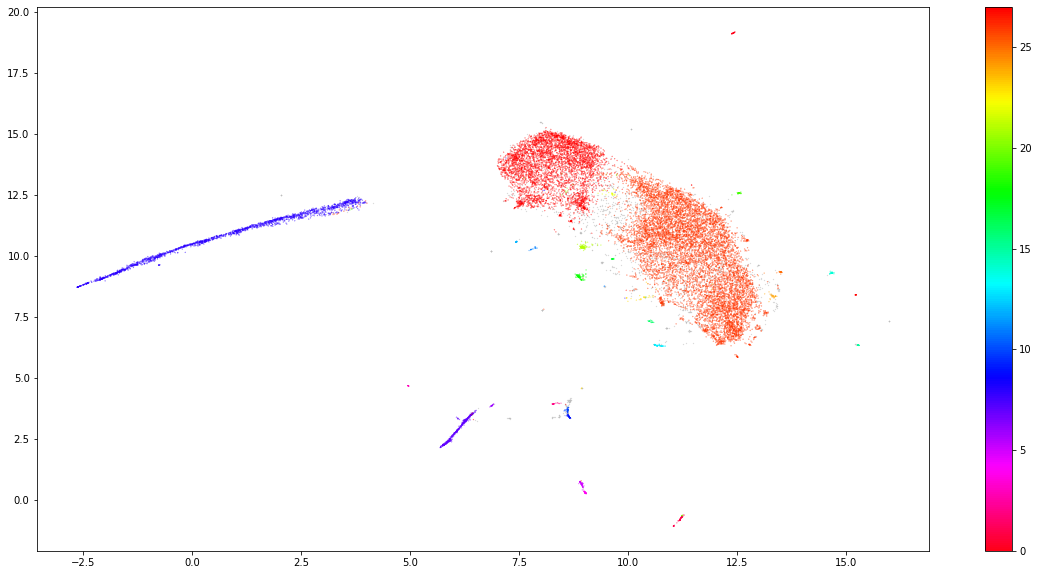

In [11]:
# Visualize clusters
fig, ax = plt.subplots(figsize=(20, 10))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=0.05)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=0.05, cmap='hsv_r')
plt.colorbar()

In [12]:
# see https://towardsdatascience.com/topic-modeling-with-bert-779f7db187e6

docs_df = pd.DataFrame(data, columns=["Doc"])
docs_df['Topic'] = cluster.labels_
docs_df['Doc_ID'] = range(len(docs_df))
docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

docs_df

,Doc,Topic,Doc_ID
0,From: Mamatha Devineni Ratnam <mr47+@andrew.cm...,27,0
1,From: mblawson@midway.ecn.uoknor.edu (Matthew ...,27,1
2,From: hilmi-er@dsv.su.se (Hilmi Eren)\nSubject...,-1,2
3,From: guyd@austin.ibm.com (Guy Dawson)\nSubjec...,26,3
4,From: Alexander Samuel McDiarmid <am2o+@andrew...,27,4
...,...,...,...
18841,From: jim.zisfein@factory.com (Jim Zisfein) \n...,-1,18841
18842,From: rdell@cbnewsf.cb.att.com (richard.b.dell...,26,18842
18843,From: westes@netcom.com (Will Estes)\nSubject:...,27,18843
18844,From: steve@hcrlgw (Steven Collins)\nSubject: ...,-1,18844


In [13]:
def c_tf_idf(documents, m, ngram_range=(1, 1)):
    count = CountVectorizer(ngram_range=ngram_range, stop_words="english").fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count
  
tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(data))

In [14]:
def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20):
    words = count.get_feature_names()
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    return top_n_words

def extract_topic_sizes(df):
    topic_sizes = (df.groupby(['Topic'])
                     .Doc
                     .count()
                     .reset_index()
                     .rename({"Topic": "Topic", "Doc": "Size"}, axis='columns')
                     .sort_values("Size", ascending=False))
    return topic_sizes

top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)
topic_sizes = extract_topic_sizes(docs_df); topic_sizes.head(10)

,Topic,Size
27,26,9190
28,27,4632
9,8,2019
0,-1,1565
8,7,488
22,21,112
19,18,93
2,1,82
6,5,61
14,13,56


In [ ]:
for i in range(20):
    # Calculate cosine similarity
    similarities = cosine_similarity(tf_idf.T)
    np.fill_diagonal(similarities, 0)

    # Extract label to merge into and from where
    topic_sizes = docs_df.groupby(['Topic']).count().sort_values("Doc", ascending=False).reset_index()
    topic_to_merge = topic_sizes.iloc[-1].Topic
    topic_to_merge_into = np.argmax(similarities[topic_to_merge + 1]) - 1

    # Adjust topics
    docs_df.loc[docs_df.Topic == topic_to_merge, "Topic"] = topic_to_merge_into
    old_topics = docs_df.sort_values("Topic").Topic.unique()
    map_topics = {old_topic: index - 1 for index, old_topic in enumerate(old_topics)}
    docs_df.Topic = docs_df.Topic.map(map_topics)
    docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

    # Calculate new topic words
    m = len(data)
    tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m)
    top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)

topic_sizes = extract_topic_sizes(docs_df); topic_sizes.head(10)